In [11]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [2]:
aisles = pd.read_csv('./data/aisles.csv')  #(134, 2)
departments = pd.read_csv('./data/departments.csv') #(21, 2)
products = pd.read_csv('./data/products.csv') # (49688, 4)
order_products_prior = pd.read_csv('./data/order_products__prior.csv') #(32434489, 4)
order_products_train = pd.read_csv('./data/order_products__train.csv') #(1384617, 4)
orders = pd.read_csv('./data/orders.csv') #(3421083, 7)

3/28 할일 
- 많이 팔린 aisle
- 주문품목 순위
- 재주문 → barplot
- 많이 팔린 department
- 재주문 빈도(날짜) → 요일과 시간별
- 주문 시간

https://www.kaggle.com/code/frednavruzov/instacart-exploratory-data-analysis

In [3]:
goods = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower() 
print(goods.shape)
goods.head()

(49688, 6)


,product_id,product_name,aisle_id,department_id,department,aisle
0,1,chocolate_sandwich_cookies,61,19,snacks,cookies cakes
1,2,all-seasons_salt,104,13,pantry,spices seasonings
2,3,robust_golden_unsweetened_oolong_tea,94,7,beverages,tea
3,4,smart_ones_classic_favorites_mini_rigatoni_wit...,38,1,frozen,frozen meals
4,5,green_chile_anytime_sauce,5,13,pantry,marinades meat preparation


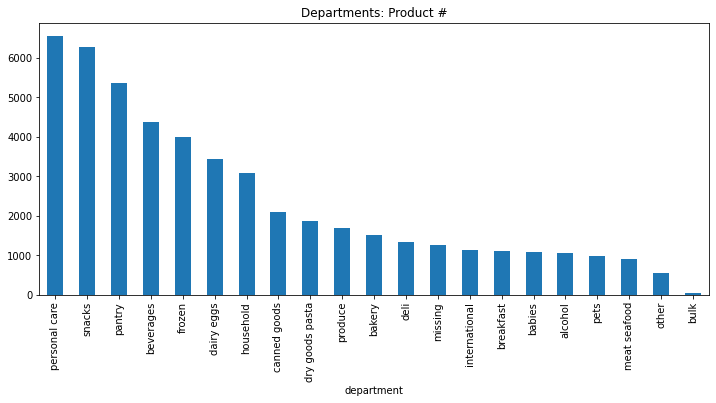

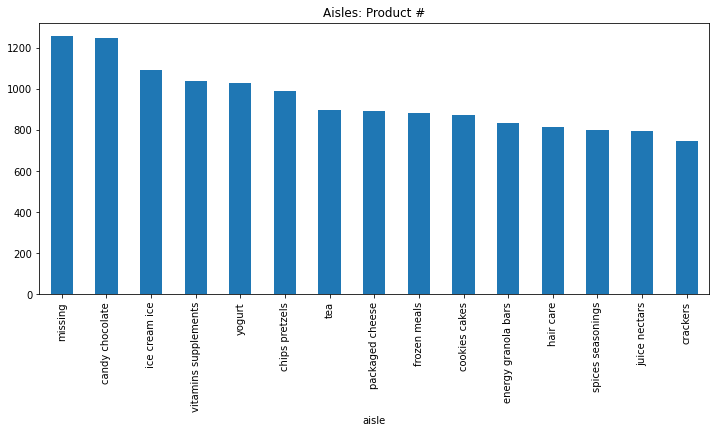

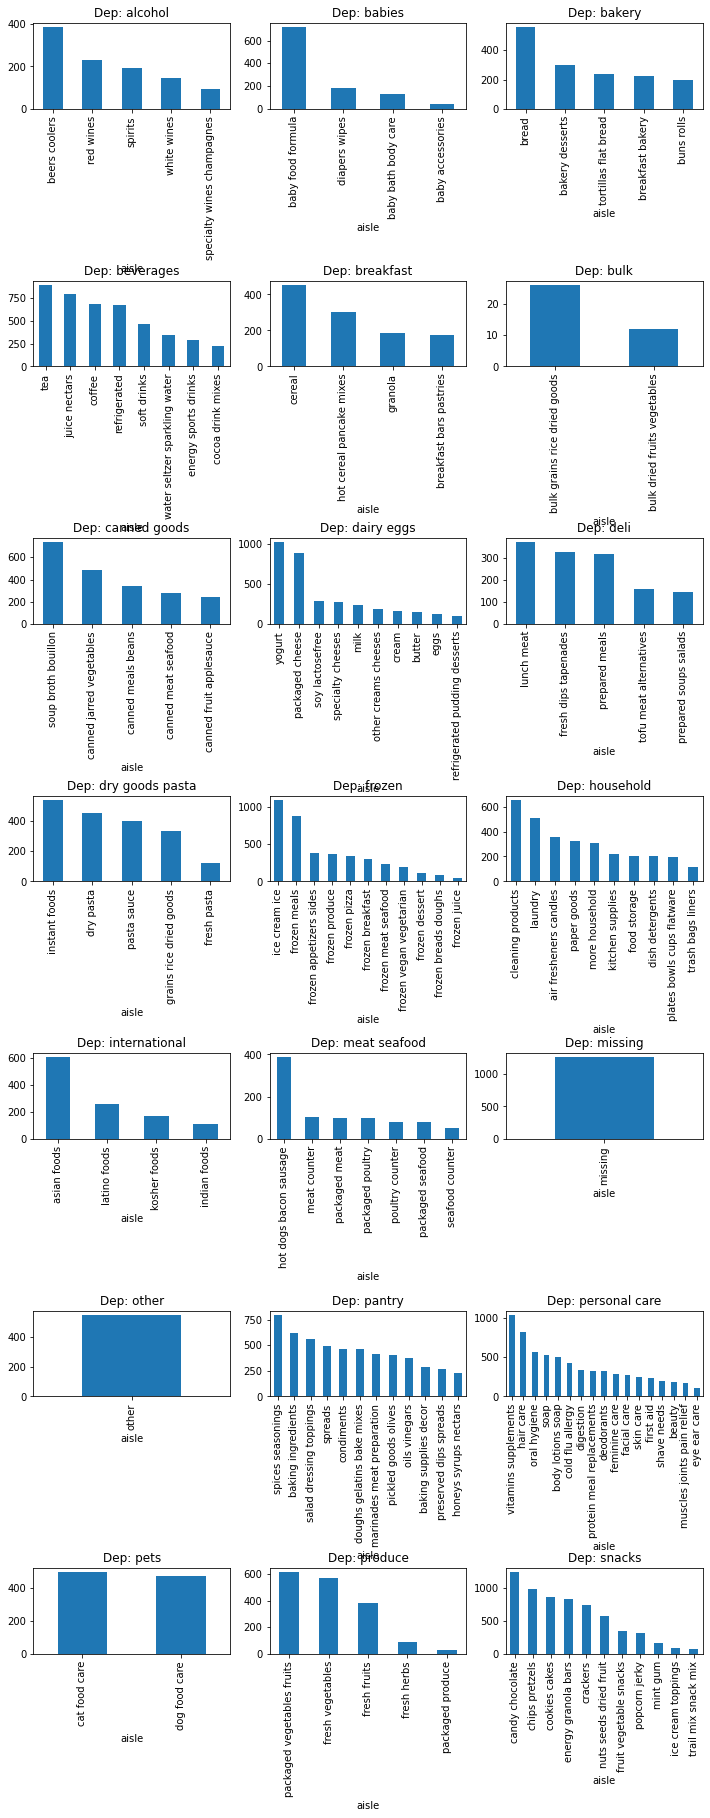

In [6]:
# departments group 의 판매 순위
plt.figure(figsize=(12, 5))
goods.groupby(['department']).count()['product_id'].copy().sort_values(ascending=False).plot(kind='bar', 
                                                                                       #figsize=(12, 5), 
                                                                                       title='Departments: Product #')
plt.show()


# aisle 의 판매 순위
top_aisles_cnt = 15
plt.figure(figsize=(12, 5))
goods.groupby(['aisle']).count()['product_id'].sort_values(ascending=False)[:top_aisles_cnt].plot(kind='bar', 
                                                                                           #figsize=(12, 5), 
                                                                                           title='Aisles: Product #')
plt.show()


# 품목별 판매량 bar plot
f, axarr = plt.subplots(7, 3, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//3, i%3].set_title('Dep: {}'.format(e))
    goods[goods.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//3, i%3])
f.subplots_adjust(hspace=2)


# grouped = goods.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
# grouped.sort_values(by='Total_products', ascending=False, inplace=True)
# fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
# for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
#     g = sns.barplot(group.aisle, group.Total_products , ax=ax)
#     ax.set(xlabel = "Aisles", ylabel=" Number of products")
#     g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
#     ax.set_title(aisle, fontsize=15)

In [8]:
grouped = goods.groupby(['aisle'])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

SpecificationError: nested renamer is not supported

In [9]:
from functools import partial

# merge train and prior together iteratively, to fit into 8GB kernel RAM
# split df indexes into parts
indexes = np.linspace(0, len(order_products_prior), num=10, dtype=np.int32)

# initialize it with train dataset
order_details = pd.merge(
                left=order_products_train,
                 right=orders, 
                 how='left', 
                 on='order_id'
        ).apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))

# add order hierarchy
order_details = pd.merge(
                left=order_details,
                right=goods[['product_id', 
                             'aisle_id', 
                             'department_id']].apply(partial(pd.to_numeric, 
                                                             errors='ignore', 
                                                             downcast='integer')),
                how='left',
                on='product_id'
)

print(order_details.shape, order_products_train.shape)

# delete (redundant now) dataframes
# del order_products_train

order_details.head()

(1384617, 12) (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9,120,16
1,1,11109,2,1,112108,train,4,4,10,9,108,16
2,1,10246,3,0,112108,train,4,4,10,9,83,4
3,1,49683,4,0,112108,train,4,4,10,9,83,4
4,1,43633,5,1,112108,train,4,4,10,9,95,15


In [ ]:
# prior 데이터 셋 크기가 커서 concat 불가.

# update by small portions
for i in range(len(indexes)-1):
    order_details = pd.concat(
        [   
            order_details,
            pd.merge(left=pd.merge(
                            left=order_products_prior.iloc[indexes[i]:indexes[i+1], :],
                            right=goods[[
                                'product_id', 
                                 'aisle_id', 
                                 'department_id'
                            ]].apply(partial(pd.to_numeric, 
                                             errors='ignore', 
                                             downcast='integer')),
                            how='left',
                            on='product_id'
                            ),
                     right=orders, 
                     how='left', 
                     on='order_id'
                ) #.apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))
        ]
    )
        
print('Datafame length: {}'.format(order_details.shape[0]))
print('Memory consumption: {:.2f} Mb'.format(sum(order_details.memory_usage(index=True, 
                                                                         deep=True) / 2**20)))
# check dtypes to see if we use memory effectively
print(order_details.dtypes)

# make sure we didn't forget to retain test dataset :D
test_orders = orders[orders.eval_set == 'test']

# delete (redundant now) dataframes
del op_prior, orders

In [16]:
# unique orders, product_ordered, users
print('Unique users: {}'.format(len(set(order_details.user_id))))
print('Unique orders: {}'.format(len(set(order_details.order_id))))
print('Unique products bought: {}/{}'.format(len(set(order_details.product_id)), len(goods)))

Unique users: 131209
Unique orders: 131209
Unique products bought: 39123/49688


In [ ]:
# 예상 했던 unique 데이터 수 
Unique users: 206209
Unique orders: 3346083
Unique products bought: 29685/49688

In [ ]:
unordered = goods[goods.product_id.isin(list(set(goods.product_id) - set(order_details.product_id)))]
print('"Lonesome" products cnt: {}/{}'.format(unordered.shape[0], len(goods)))
unordered.head()

In [ ]:
# popular products (total set, not only train)
top = 15
top_products = pd.merge(
    # to see train: 
    # left=pd.DataFrame(order_details[order_details.eval_set == 'train'].groupby(['product_id'])['order_id']\
    left=pd.DataFrame(order_details.groupby(['product_id'])['order_id']\
    .apply(lambda x: len(x.unique())).sort_values(ascending=False)[:top].reset_index('product_id')),
    right=goods,
    how='left')

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(top_products.product_name, top_products.order_id)
plt.ylabel('Number of Orders, Containing This Product')
plt.xlabel('Product Name')

In [ ]:
# most "frequently" bought products (total set, not only train)
# most "frequently" ~ time between orders (within selected customer's orders), 
# that contain that product, is the least 
#(products, which were bought by more than 100 customers, to omit outliers)
top = 15
customer_limit = 100

temp = order_details.groupby(['product_id'])[['days_since_prior_order', 'user_id']]\
.aggregate({'days_since_prior_order': np.mean, 'user_id': len}).reset_index()

frequent_products = pd.merge(
    left=pd.DataFrame(temp[temp.user_id > customer_limit].sort_values(['days_since_prior_order'], 
                                                                      ascending=True)[:top]),
    right=goods,
    how='left')

plt.figure(figsize=(12,6))
plt.xticks(rotation='vertical')
sns.barplot(frequent_products.product_name, frequent_products.days_since_prior_order)
plt.ylabel('Average Days Between Orders, Containing This Product')
plt.xlabel('Product Name')

del temp

# order_products_prior 와 train 을 합쳐서 전체적으로 bestsellers 을 보고싶은데 .. 흠 메모리 에러 난다 : dead kernel

- 아래 코드는 동작 하지만 데이터셋을 합치지 못한채로 돌렸기 때문에 틀린 정보이다.

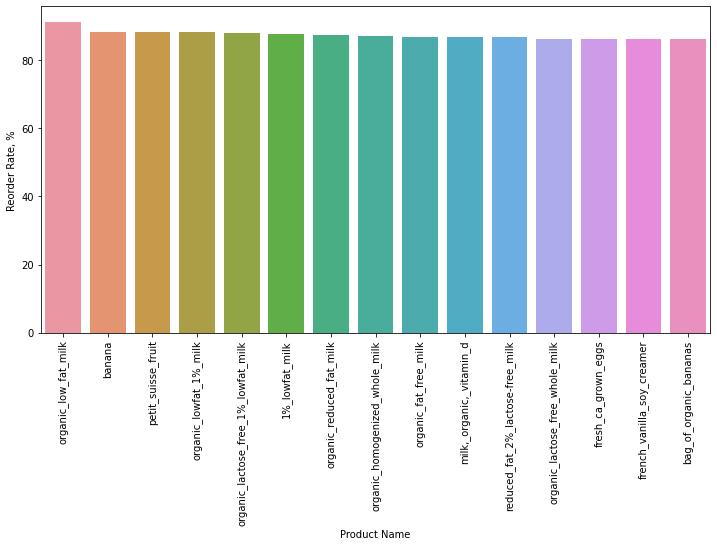

In [12]:
# consider products, purchased in more than X orders
order_limit = 100
top = 15

mo_products = order_details.groupby('product_id')[['reordered', 'order_id']]\
.aggregate({'reordered': sum, 'order_id': len}).reset_index()
mo_products.columns = ['product_id', 'reordered', 'order_cnt']

mo_products['reorder_rate'] = mo_products['reordered'] / mo_products['order_cnt']
mo_products = mo_products[mo_products.order_cnt > order_limit].sort_values(['reorder_rate'], 
                                                                           ascending=False)[:top]

mo_products = pd.merge(
    left=mo_products,
    right=goods,
    on='product_id')
mo_products

# plot it
plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(mo_products.product_name, mo_products.reorder_rate*100)
plt.ylabel('Reorder Rate, %')
plt.xlabel('Product Name')
pass

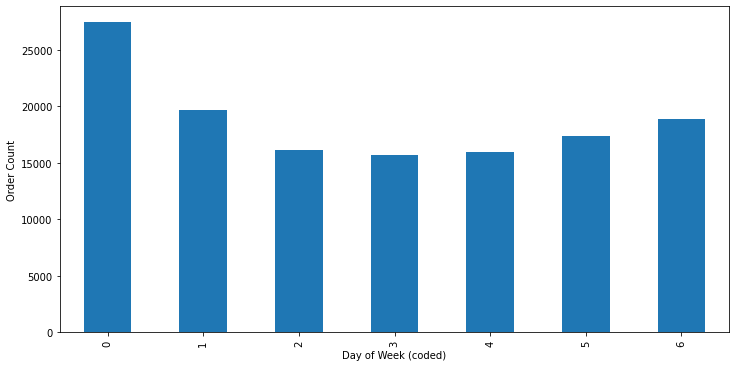

In [13]:
# orders 의 요일별  count 
plt.figure(figsize=(12,6))
order_details.groupby('order_dow')['order_id'].apply(lambda x: len(x.unique())).plot(kind='bar')
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Day of Week (coded)')
pass

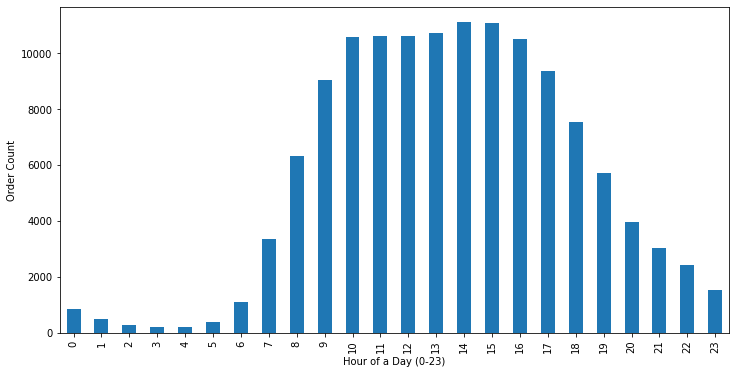

In [14]:
# orders 의 시간별  count 
plt.figure(figsize=(12,6))
order_details.groupby('order_hour_of_day')['order_id'].apply(lambda x: 
                                                             len(x.unique())).plot(kind='bar')
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Hour of a Day (0-23)')
pass

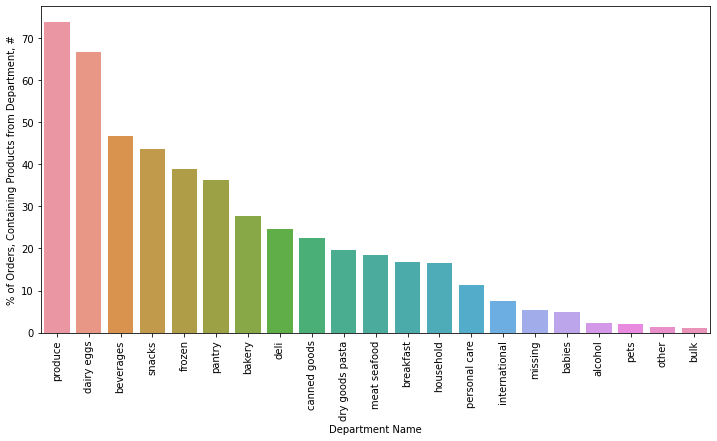

In [15]:
# 그래서 뭐가 가장 잘 팔리냐!
pop_dep = pd.merge(
    left=order_details.groupby('department_id')['order_id'].apply(lambda x: 
                                                                  len(x.unique())).reset_index(),
    right=goods[['department_id', 'department']].drop_duplicates(),
    how='inner',
    on='department_id'
).sort_values(['order_id'], ascending=False)

# plot it
total_orders = len(set(order_details.order_id))

plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(pop_dep.department, pop_dep.order_id / total_orders * 100)
plt.ylabel('% of Orders, Containing Products from Department, #')
plt.xlabel('Department Name')
pass